In [1]:
import os
import sys
import pandas as pd
import numpy as np
import random

import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler

from keras.utils import Sequence

from tensorflow.keras import backend
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

sys.path.append('path_to_your_file/template')
from template.callback_manager import CallbackManager

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [2]:
class DataGenerator(Sequence):
    def __init__(self, data, positive_patients, negative_patients, batch_size, steps_per_epoch, step=1):
        
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        
        self.data = data
        
        self.positive_patients = positive_patients
        self.negative_patients = negative_patients
        
        self.sub_positive_patients = self.positive_patients[:self.steps_per_epoch]
        self.sub_negative_patients = self.negative_patients[:self.steps_per_epoch]
        self.sub_patients = np.concatenate((self.sub_positive_patients , self.sub_negative_patients), axis=0)
        
        self.batches_num = len(self.sub_patients )
        self.rs = np.random.RandomState(1000)
        self.is_positive = False
        
    def __getitem__(self, current_id):
        if self.is_positive:
            current_id = random.choice(self.sub_positive_patients)
            df = self.data[self.data['patient_id'] == current_id]
            self.is_positive = False
        else:
            
            current_id = random.choice(self.sub_negative_patients)
            df = self.data[self.data['patient_id'] == current_id]
            self.is_positive = True
        
        
        sequence_lengths = int(df["sequence_lengths"].iloc[0])
        df = df.iloc[:sequence_lengths+1]
        
        df = df.drop('sequence_lengths', axis=1)
        df = df.drop('patient_id', axis=1)
        
        label = int(df["recovery_flags"].iloc[-1])
        df = df.drop('recovery_flags', axis=1)
        
        sequence = df.values
        return sequence, label

        
    def __len__(self):
        return self.batches_num
    
    
    def on_epoch_end(self):
        if 1:
            self.rs.shuffle(self.positive_patients)
            self.rs.shuffle(self.negative_patients)
            
            self.sub_positive_patients = self.positive_patients[:self.steps_per_epoch]
            self.sub_negative_patients = self.negative_patients[:self.steps_per_epoch]
            self.sub_patients = np.concatenate((self.sub_positive_patients , self.sub_negative_patients), axis=0)

In [3]:
# Determining numpy and tensorflow
np.random.seed(1000)
tf.compat.v1.set_random_seed(1000)
tf.random.set_seed(1000)
from tqdm import tqdm
import matplotlib.pyplot as plt

ROOT_DIR = os.getcwd()
print("ROOT_DIR: ", ROOT_DIR)
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
    
INPUT_LAYER = 'input_layer'
INPUT_SHAPE = 6
    

def validate_model(lstm_model,
                   data_generator,
                   loss_function):

    batches_num = data_generator.batches_num
    val_loss = 0
    accuracy = 0
    for batch in tqdm(data_generator, desc="Model is validating..."):
        sequence, true_detection = batch

        lstm_model.reset_states()
        prediction = predict(lstm_model, sequence)
        
        pred = 1 if prediction[0] >= 0.5 else 0
        
        if pred == true_detection:
            accuracy += 1
       
        true_detection = np.array([[true_detection]])
        val_loss += backend.get_value(loss_function(true_detection, prediction))

    return val_loss / batches_num, accuracy / batches_num


def train_model(lstm_model, data_generator):

    batches_num = data_generator.batches_num
    train_loss = 0
    for sequence in tqdm(data_generator, desc="Model is training..."):
        train_loss += train_on_sequence(lstm_model, sequence)

    return train_loss / batches_num


def predict(lstm_model, sequence):
    
    prediction = None
    for element in list(sequence):
        element = element[np.newaxis, ...]
        prediction = lstm_model.predict_on_batch(x=element)
    return prediction


def train_on_sequence(lstm_model,
                      sample):

    lstm_model.reset_states()

    frames, true_detection = sample
    
    true_detection = np.array([[true_detection]])
    
    
    for frame in list(frames[:-1]):
        frame = frame[np.newaxis, ...]
        lstm_model.predict_on_batch(x=frame)

    train_input = frames[-1]
    
    train_input = train_input[np.newaxis, ...]

    return lstm_model.train_on_batch(x=train_input, y=true_detection)


def plot_losses(losses,
                val_losses,
                epochs,
                logs_dir):
 
    n = np.arange(1, epochs)
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(n, losses, label='train_loss')
    plt.plot(n, val_losses, label='val_loss')
    plt.title('Training and validation losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.legend()
    plt.savefig(os.path.join(logs_dir, '{}_{}.png'.format('Losses', epochs)))
    plt.close()
               

callback_parameters = {
                "logs_dir": "logs",
                "lr_reduce_patience": 15,
                "lr_reduce_factor": 0.5,
                "lr_reduce_min_lr":  0.0000001,
                "lr_reduce_min_delta":  0.001
            }


class LstmModelManager:
    def __init__(self,
                 train_mode: bool = False):
               
        self._loss_name = "binary_crossentropy"
        self._loss = tf.keras.losses.BinaryCrossentropy()

        abs_path_to_model = os.path.join(ROOT_DIR, "lstm_model", "model.hdf5")
        self._path_to_model = abs_path_to_model

        abs_path_to_model_folder, model_name = os.path.split(abs_path_to_model)
        os.makedirs(abs_path_to_model_folder, exist_ok=True)
        
        self._path_to_best_model = os.path.join(ROOT_DIR, "best_lstm_model", "model.hdf5")
        os.makedirs(os.path.join(ROOT_DIR, "best_lstm_model"), exist_ok=True)

        if train_mode:
               
            self._optimizer = Adam(lr=0.0001,
                                   epsilon=0.000001)

            self._callback_manager = CallbackManager(callback_parameters)
            self._patience = callback_parameters["lr_reduce_patience"]
            logs_dir = callback_parameters["logs_dir"]
            self._path_to_logs = os.path.join(abs_path_to_model_folder, logs_dir)
            os.makedirs(self._path_to_logs, exist_ok=True)
            self._lstm_model = self._build_multi_model(INPUT_SHAPE)

    @property
    def loss(self):
        return self._loss

    def _build_multi_model(self,
                           input_shape):
        input_row = Input(batch_shape=(1, input_shape), name=INPUT_LAYER)


        output_layer = Reshape(target_shape=(1, input_shape))(input_row)

        output_layer = LSTM(16,
                              return_sequences=True,
                              dropout=0.2,
                              batch_input_shape=(1, 1, input_shape),
                              stateful=True)(output_layer)

        output_layer = Flatten()(output_layer)
        output_layer = Dense(8, activation='relu')(output_layer)
        output_layer = Dropout(0.1)(output_layer)

        output_layer = Dense(1, activation="sigmoid")(output_layer)

        model = Model(inputs=input_row, outputs=output_layer)
        return self._compile_model(model)

    def _update_training_parameters(self, val_loss):
        current_lr = self._lstm_model.optimizer.learning_rate
        new_lr = self._callback_manager.get_reduced_lr(val_loss, current_lr.numpy())
        backend.set_value(current_lr, new_lr)

    def _compile_model(self, model):
        model.compile(loss=self._loss, optimizer=self._optimizer)
        return model

    def _save_model(self, path_to_model=None):
        if path_to_model is None:
            self._lstm_model.save(self._path_to_model)
        else:
            self._lstm_model.save(path_to_model)

    def load_model(self, path_to_model=None):
        if path_to_model is None:
            lstm_model = load_model(self._path_to_model,
                                    custom_objects={self._loss_name: self._loss})
        else:
            lstm_model = load_model(path_to_model, custom_objects={self._loss_name: self._loss})
        self._lstm_model = lstm_model
        return lstm_model
               
               
    def fit_model(self,
                  train_data_generator: DataGenerator,
                  valid_data_generator: DataGenerator,
                  epoch_num: int):
        valid_losses = []
        training_losses = []

        for epoch_index in range(1, epoch_num + 1):
            train_loss = train_model(self._lstm_model, train_data_generator)

            self._save_model()
            backend.clear_session()
            _ = self.load_model()

            val_loss, val_accuracy = validate_model(self._lstm_model, valid_data_generator, self._loss)

            if epoch_index > 1 and val_loss < min(valid_losses):
                self._save_model(self._path_to_best_model)

            if epoch_index % self._patience == 0:
                self._update_training_parameters(valid_losses)
                plot_losses(training_losses, valid_losses, epoch_index, self._path_to_logs)

            training_losses.append(train_loss)
            valid_losses.append(val_loss)
            
            
            train_data_generator.on_epoch_end()
            valid_data_generator.on_epoch_end()


            print('train loss: {} on epoch num: {}'.format(train_loss, epoch_index))
            print('val_loss: {} on epoch num: {}'.format(val_loss, epoch_index))
            print('val_accuracy: {} on epoch num: {}'.format(val_accuracy, epoch_index))
        
        plot_losses(training_losses,
                valid_losses,
                epoch_num,
                ROOT_DIR)


    def evaluate_model(self, data_generator):
        backend.clear_session()
        self._lstm_model = self.load_model(self._path_to_best_model)
        loss_value = validate_model(self._lstm_model, data_generator, self._loss)
        self._lstm_model.reset_states()
        return loss_value



ROOT_DIR:  /Users/kirilerosenco/Desktop/Архив1


In [4]:
def separate_to_positive_and_negative(data_f, patients):
    positive_patients = []
    negative_patients = []
    
    for patient in patients:
        filtered_df = data_f[data_f['patient_id'] == patient]
        unique_values = list(filtered_df['recovery_flags'].unique())
        flag = max(unique_values)
        if flag == 1.:
            positive_patients.append(patient)
        elif flag == 0.:
            negative_patients.append(patient)
        else:
            raise ValueError("LOL, error")
    return positive_patients, negative_patients

In [5]:
num_timesteps = 60
epoch_num = 30 # for model training
steps_per_epoch = 30  # for model training

data_1 = pd.read_csv('data_g.csv')
data_2 = pd.read_csv('data_g2.csv')
data_3 = pd.read_csv('data_g3.csv')
data_4 = pd.read_csv('data_g4.csv') 


train = pd.concat([data_2, data_3], ignore_index=True).reset_index(drop=True)
train = train.drop('index', axis = 1)
train_num_patients = len(train) // num_timesteps
train_patient_id = np.repeat(np.arange(train_num_patients), num_timesteps)
train['patient_id'] = train_patient_id


valid = data_4.drop('index', axis = 1)
valid_num_patients = len(valid) // num_timesteps
valid_patient_id = np.repeat(np.arange(valid_num_patients), num_timesteps)
valid['patient_id'] = valid_patient_id


test = data_1.drop('index', axis = 1)
test_num_patients = len(test) // num_timesteps
test_patient_id = np.repeat(np.arange(test_num_patients), num_timesteps)
test['patient_id'] = test_patient_id



In [6]:
positive_train_patients, negative_train_patients = separate_to_positive_and_negative(train, set(train_patient_id))
positive_valid_patients, negative_valid_patients = separate_to_positive_and_negative(valid, set(valid_patient_id))

print("train: ", len(positive_train_patients), len(negative_train_patients))
print("valid: ", len(positive_valid_patients), len(negative_valid_patients))


train:  581 19419
valid:  304 9696


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.99it/s]


train loss: 0.6998658259709676 on epoch num: 1
val_loss: 0.69317453900973 on epoch num: 1
val_accuracy: 0.5166666666666667 on epoch num: 1


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 13.70it/s]


train loss: 0.647560141980648 on epoch num: 2
val_loss: 0.6192991365989049 on epoch num: 2
val_accuracy: 0.7833333333333333 on epoch num: 2


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 13.06it/s]


train loss: 0.5869372377792994 on epoch num: 3
val_loss: 0.5182434077064196 on epoch num: 3
val_accuracy: 0.8 on epoch num: 3


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 13.78it/s]


train loss: 0.5492147490382194 on epoch num: 4
val_loss: 0.5002027069528897 on epoch num: 4
val_accuracy: 0.8333333333333334 on epoch num: 4


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.46it/s]


train loss: 0.4976067235072454 on epoch num: 5
val_loss: 0.46775376896063486 on epoch num: 5
val_accuracy: 0.8166666666666667 on epoch num: 5


Model is validating...: 100%|██████████| 60/60 [00:05<00:00, 10.82it/s]


train loss: 0.4475233186036348 on epoch num: 6
val_loss: 0.4766917342940966 on epoch num: 6
val_accuracy: 0.85 on epoch num: 6


Model is validating...: 100%|██████████| 60/60 [00:03<00:00, 15.44it/s]


train loss: 0.39555800246695677 on epoch num: 7
val_loss: 0.3100666863222917 on epoch num: 7
val_accuracy: 0.9166666666666666 on epoch num: 7


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 12.87it/s]


train loss: 0.30074551527698834 on epoch num: 8
val_loss: 0.3693607417245706 on epoch num: 8
val_accuracy: 0.8833333333333333 on epoch num: 8


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 13.44it/s]


train loss: 0.3773196411629518 on epoch num: 9
val_loss: 0.3732495882858833 on epoch num: 9
val_accuracy: 0.85 on epoch num: 9


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.31it/s]


train loss: 0.3962815109019478 on epoch num: 10
val_loss: 0.44528850466012954 on epoch num: 10
val_accuracy: 0.8333333333333334 on epoch num: 10


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.88it/s]


train loss: 0.2947747005770604 on epoch num: 11
val_loss: 0.306591892739137 on epoch num: 11
val_accuracy: 0.9333333333333333 on epoch num: 11


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 12.12it/s]


train loss: 0.48725967618326343 on epoch num: 12
val_loss: 0.44252094328403474 on epoch num: 12
val_accuracy: 0.8166666666666667 on epoch num: 12


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 13.47it/s]


train loss: 0.3754041823248068 on epoch num: 13
val_loss: 0.294935452627639 on epoch num: 13
val_accuracy: 0.9333333333333333 on epoch num: 13


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 13.94it/s]


train loss: 0.4351608611022433 on epoch num: 14
val_loss: 0.25699561468015114 on epoch num: 14
val_accuracy: 1.0 on epoch num: 14


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.04it/s]


Learning rate reduced from 0.0010000000474974513 to 0.0005000000237487257
train loss: 0.3428613381460309 on epoch num: 15
val_loss: 0.4388614525397619 on epoch num: 15
val_accuracy: 0.8833333333333333 on epoch num: 15


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 13.62it/s]


train loss: 0.354865059008201 on epoch num: 16
val_loss: 0.34004551768302915 on epoch num: 16
val_accuracy: 0.9333333333333333 on epoch num: 16


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.82it/s]


train loss: 0.3390682766834895 on epoch num: 17
val_loss: 0.2636979348336657 on epoch num: 17
val_accuracy: 0.9333333333333333 on epoch num: 17


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.60it/s]


train loss: 0.34649030019839605 on epoch num: 18
val_loss: 0.29626698084175584 on epoch num: 18
val_accuracy: 0.9666666666666667 on epoch num: 18


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.52it/s]


train loss: 0.4382321900377671 on epoch num: 19
val_loss: 0.35892289063582816 on epoch num: 19
val_accuracy: 0.9166666666666666 on epoch num: 19


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 12.76it/s]


train loss: 0.26672209228078525 on epoch num: 20
val_loss: 0.24481714156766732 on epoch num: 20
val_accuracy: 0.9 on epoch num: 20


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.78it/s]


train loss: 0.29045492863903444 on epoch num: 21
val_loss: 0.23529171316574019 on epoch num: 21
val_accuracy: 0.9166666666666666 on epoch num: 21


Model is validating...: 100%|██████████| 60/60 [00:05<00:00, 11.57it/s]


train loss: 0.1813645629522701 on epoch num: 22
val_loss: 0.3482174482817451 on epoch num: 22
val_accuracy: 0.8666666666666667 on epoch num: 22


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.03it/s]


train loss: 0.33351062623163064 on epoch num: 23
val_loss: 0.28162470723812777 on epoch num: 23
val_accuracy: 0.8833333333333333 on epoch num: 23


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.06it/s]


train loss: 0.3181969237824281 on epoch num: 24
val_loss: 0.21168929866204658 on epoch num: 24
val_accuracy: 0.9333333333333333 on epoch num: 24


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.53it/s]


train loss: 0.20054176390791933 on epoch num: 25
val_loss: 0.17362358508010706 on epoch num: 25
val_accuracy: 1.0 on epoch num: 25


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.13it/s]


train loss: 0.40695813574517764 on epoch num: 26
val_loss: 0.18189505754659574 on epoch num: 26
val_accuracy: 1.0 on epoch num: 26


Model is validating...: 100%|██████████| 60/60 [00:03<00:00, 15.10it/s]


train loss: 0.30249926960095763 on epoch num: 27
val_loss: 0.26582937271644674 on epoch num: 27
val_accuracy: 0.9166666666666666 on epoch num: 27


Model is validating...: 100%|██████████| 60/60 [00:03<00:00, 15.24it/s]


train loss: 0.2546627173045029 on epoch num: 28
val_loss: 0.14264955874532462 on epoch num: 28
val_accuracy: 0.9833333333333333 on epoch num: 28


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 13.97it/s]


train loss: 0.25869778338819743 on epoch num: 29
val_loss: 0.20854452991237243 on epoch num: 29
val_accuracy: 0.9833333333333333 on epoch num: 29


Model is validating...: 100%|██████████| 60/60 [00:04<00:00, 14.04it/s]


Learning rate reduced from 0.0005000000237487257 to 0.0002500000118743628
train loss: 0.15590116328870257 on epoch num: 30
val_loss: 0.41375161446630954 on epoch num: 30
val_accuracy: 0.85 on epoch num: 30


ValueError: x and y must have same first dimension, but have shapes (29,) and (30,)

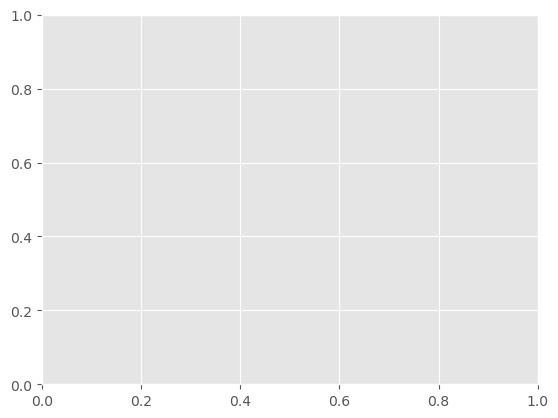

In [7]:
train_data_generator = DataGenerator(data=train,
                                     positive_patients=positive_train_patients, 
                                     negative_patients=negative_train_patients, 
                                     batch_size=1, steps_per_epoch=steps_per_epoch, step=1)


valid_data_generator = DataGenerator(data=valid,
                                     positive_patients=positive_valid_patients, 
                                     negative_patients=negative_valid_patients, 
                                     batch_size=1, steps_per_epoch=steps_per_epoch,
                                     step=1)


model_manager = LstmModelManager(train_mode=True)

model_manager.fit_model(train_data_generator=train_data_generator,
                        valid_data_generator=valid_data_generator,
                        epoch_num=epoch_num)


In [8]:
positive_test_patients, negative_test_patients = separate_to_positive_and_negative(test, set(test_patient_id))
print("test: ", len(positive_test_patients), len(negative_test_patients))

test:  315 9685


In [9]:
len(positive_test_patients)

315

In [10]:
negative_test_patients = negative_test_patients[:315]
len(negative_test_patients)

315

In [11]:
reduced_test_patients = positive_test_patients + negative_test_patients

In [12]:
true_labels = []
predicted_labels = []

for patient in tqdm(reduced_test_patients):
    backend.clear_session()
    best_model = load_model(os.path.join(ROOT_DIR, "best_lstm_model", "model.hdf5"))
    
    test_sub = test[test['patient_id'] == patient]
    sequence_lengths = int(test_sub["sequence_lengths"].iloc[0])
    test_sub = test_sub.iloc[:sequence_lengths+1]

    test_sub = test_sub.drop('sequence_lengths', axis=1)
    test_sub = test_sub.drop('patient_id', axis=1)

    true_detection = int(test_sub["recovery_flags"].iloc[-1])
    test_sub = test_sub.drop('recovery_flags', axis=1)

    sequence = test_sub.values
    
        
    true_labels.append(true_detection)
    prediction = predict(best_model, sequence)
    
    if prediction[0] >= 0.5:
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

    best_model.reset_states()


  4%|▎         | 23/630 [00:06<03:03,  3.31it/s]

  5%|▍         | 29/630 [00:08<02:46,  3.60it/s]

100%|██████████| 630/630 [03:31<00:00,  2.98it/s]


In [13]:

# calculate precision and recall for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)

# print the results
print('Precision:', precision)
print('Recall:', recall)


Precision: [0.91150442 0.97938144]
Recall: [0.98095238 0.9047619 ]


In [14]:
confusion_matrix(true_labels, predicted_labels)

array([[309,   6],
       [ 30, 285]])